In [ ]:
!pip install -q tensorflow matplotlib opencv-python scikit-learn tqdm

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle
from tqdm import tqdm

# Random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Download GTSRB dataset
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

# Extract the datasets
!unzip -q GTSRB_Final_Training_Images.zip
!unzip -q GTSRB_Final_Test_Images.zip
!unzip -q GTSRB_Final_Test_GT.zip

# Define paths
train_path = 'GTSRB/Final_Training/Images/'
test_path = 'GTSRB/Final_Test/Images/'

--2025-05-22 10:49:31--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  27.6MB/s    in 10s     

2025-05-22 10:49:42 (25.4 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]

--2025-05-22 10:49:42--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.8

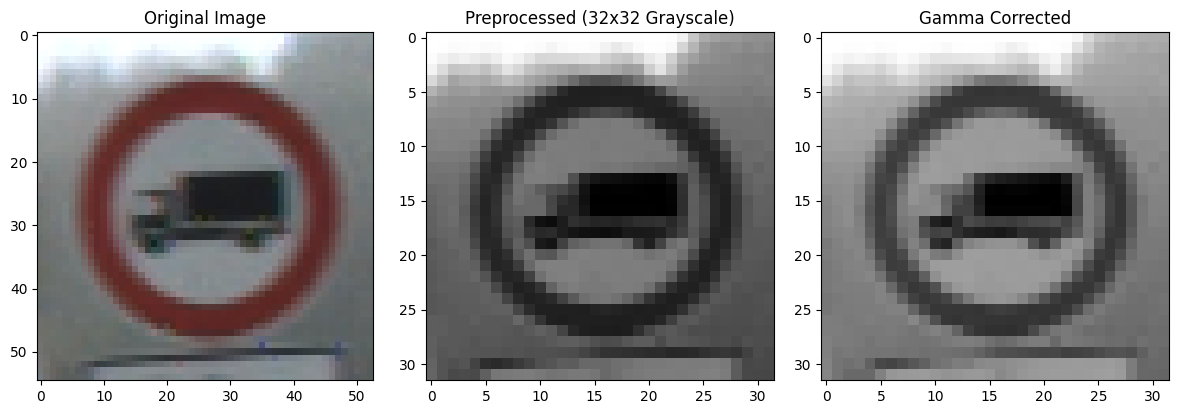

We'll load the full dataset in the next cell


In [ ]:
def preprocess_dataset(image_path, img_size=32, is_grayscale=True):
    """
    Load and preprocess an image from the GTSRB dataset
    - Resize to 32x32 (sweet spot mentioned in the presentation)
    - Convert to grayscale
    """
    img = cv2.imread(image_path)
    # Resize image
    img = cv2.resize(img, (img_size, img_size))

    # Convert to grayscale if required
    if is_grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img, axis=-1)  # Add channel dimension

    # Normalize pixel values
    img = img / 255.0

    return img

def gamma_correction(image, gamma=1.0):
    """
    Apply gamma correction to handle exposure differences
    as mentioned in the presentation (slide 5)
    """
    # Convert to float to avoid overflow
    image_float = image.astype(float)

    # Apply gamma correction
    corrected = np.power(image_float, gamma)

    # Scale back to [0, 1] range
    corrected = corrected / np.max(corrected)

    return corrected

def load_training_data():
    """
    Load and preprocess the GTSRB training dataset
    """
    images = []
    labels = []

    # Loop through all classes (43 in total)
    for c in tqdm(range(0, 43)):
        prefix = train_path + format(c, '05d') + '/'
        gt_file = open(prefix + 'GT-' + format(c, '05d') + '.csv')
        gt_reader = pd.read_csv(gt_file, delimiter=';')
        gt_reader = gt_reader.iloc[1:]  # Skip header

        # Loop through all images in current class
        for idx, row in gt_reader.iterrows():
            # Get image filename
            img_path = prefix + row[0]

            # Process image
            img = preprocess_dataset(img_path)

            # Add to dataset
            images.append(img)
            labels.append(c)

    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    return X, y

# Demonstrate preprocessing on a sample image
sample_class = '00016'
sample_img_path = f"{train_path}{sample_class}/00000_00000.ppm"

# Original image
orig_img = cv2.imread(sample_img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

# Preprocessed image
prep_img = preprocess_dataset(sample_img_path)
prep_img_gamma = gamma_correction(prep_img, gamma=0.5)

# Display
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original Image")
plt.imshow(orig_img)
plt.subplot(132)
plt.title("Preprocessed (32x32 Grayscale)")
plt.imshow(prep_img.squeeze(), cmap='gray')
plt.subplot(133)
plt.title("Gamma Corrected")
plt.imshow(prep_img_gamma.squeeze(), cmap='gray')
plt.tight_layout()
plt.show()

print("We'll load the full dataset in the next cell")

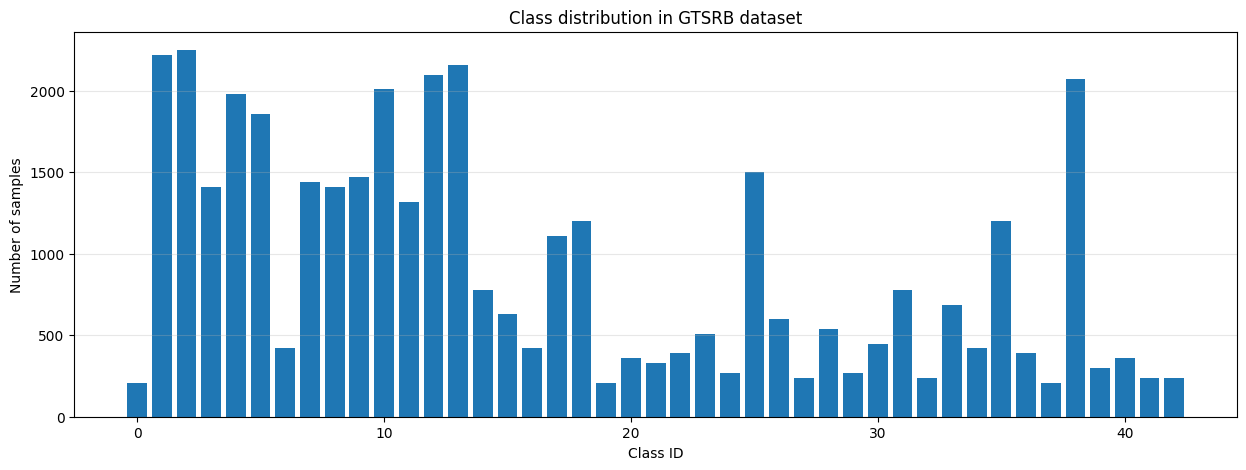

Ready to load full dataset. This might take a few minutes...
Loading training data...


  0%|          | 0/43 [00:00<?, ?it/s]

GTSRB/Final_Training/Images/00000/
GTSRB/Final_Training/Images/00000/GT-00000.csv


<ipython-input-4-0ea1a472e6d4>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(prefix, row[0])
<ipython-input-4-0ea1a472e6d4>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(prefix, row[0])
  5%|▍         | 2/43 [00:00<00:19,  2.09it/s]<ipython-input-4-0ea1a472e6d4>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(prefix, row[0])
  7%|▋         | 3/43 [00:0

Loading test data...


0it [00:00, ?it/s]<ipython-input-4-0ea1a472e6d4>:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(test_path, row[0])
<ipython-input-4-0ea1a472e6d4>:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[7]
12630it [00:04, 3083.17it/s]


Dataset loaded: 39166 training samples, 12629 test samples
Image shape: (32, 32, 1)


In [ ]:
# Set parameters as per the presentation
IMG_SIZE = 32  # The "sweet spot" mentioned in the presentation
USE_GRAYSCALE = True
BATCH_SIZE = 32


def load_and_preprocess_data():
    """
    Load and preprocess the entire GTSRB dataset
    """
    print("Loading training data...")
    X_train = []
    y_train = []

    xd = True

    # Loop through all 43 traffic sign classes
    for c in tqdm(range(43)):
        # Format class id with leading zeros
        prefix = os.path.join(train_path, f'{c:05d}/')
        gt_file = os.path.join(prefix, f'GT-{c:05d}.csv')
        if(xd):
          print(prefix)
          print(gt_file)
          xd = False

        # Read annotations
        gt_data = pd.read_csv(gt_file, sep=';')

        # Process each image in the class
        for idx, row in gt_data.iterrows():
            if idx == 0:  # Skip header
                continue

            # Get image path
            img_path = os.path.join(prefix, row[0])

            # Preprocess image
            img = preprocess_dataset(img_path, IMG_SIZE, USE_GRAYSCALE)

            # Apply gamma correction as data augmentation
            if np.random.random() < 0.3:  # Apply to 30% of images
                gamma = np.random.uniform(0.4, 1.5)  # Random gamma value
                img = gamma_correction(img, gamma)

            # Add to dataset
            X_train.append(img)
            y_train.append(c)

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Shuffle data
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    # Load test data (using the Test.csv file)
    print("Loading test data...")
    test_annotations = pd.read_csv('GT-final_test.csv', sep=';')
    X_test = []
    y_test = []

    for idx, row in tqdm(test_annotations.iterrows()):
        if idx == 0:  # Skip header
            continue

        # Get image path and label
        img_path = os.path.join(test_path, row[0])
        label = row[7]

        # Preprocess image
        img = preprocess_dataset(img_path, IMG_SIZE, USE_GRAYSCALE)

        # Add to dataset
        X_test.append(img)
        y_test.append(label)

    # Convert to numpy arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(f"Dataset loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")
    print(f"Image shape: {X_train[0].shape}")

    return X_train, y_train, X_test, y_test

# Check dataset class distribution before loading the full dataset
class_counts = {}
for c in range(43):
    prefix = os.path.join(train_path, f'{c:05d}/')
    gt_file = os.path.join(prefix, f'GT-{c:05d}.csv')
    gt_data = pd.read_csv(gt_file, sep=';')
    class_counts[c] = len(gt_data) - 1  # Subtract 1 for header

# Plot class distribution
plt.figure(figsize=(15, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class ID')
plt.ylabel('Number of samples')
plt.title('Class distribution in GTSRB dataset')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Ready to load full dataset. This might take a few minutes...")
# Uncomment the next line to load the full dataset
X_train, y_train, X_test, y_test = load_and_preprocess_data()

In [ ]:
def create_giordynet_model():
    """
    Create the GiordyNet model architecture as described in the presentation
    - Input: 32x32x1 (grayscale image)
    - 3 convolutional blocks with MaxPooling, BatchNorm, and ReLU
    - 2 Dense layers
    - Output: 43 classes
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(10, kernel_size=(3, 3), padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        ReLU(),

        # Second Convolutional Block
        Conv2D(50, kernel_size=(3, 3), padding='valid'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        ReLU(),

        # Third Convolutional Block
        Conv2D(100, kernel_size=(3, 3), padding='valid'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        ReLU(),

        # Flatten and Dense layers
        Flatten(),
        Dense(100),
        ReLU(),
        Dense(43, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and display the model summary
giordynet = create_giordynet_model()
giordynet.summary()

# Visualize the model architecture
from tensorflow.keras.utils import plot_model

# Try to create a visualization of the model architecture
try:
    # Install graphviz if not already installed
    !apt-get install -y graphviz
    !pip install pydot

    # Plot the model
    plot_model(giordynet, to_file='giordynet_architecture.png', show_shapes=True, show_layer_names=True)

    # Display the image
    from IPython.display import Image
    Image('giordynet_architecture.png')
except Exception as e:
    print(f"Could not create model visualization: {e}")
    print("Continuing without visualization...")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 15, 15, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 50)     │         4,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 50)       │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 6, 6, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 100)      │        45,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 100)      │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 2, 2, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         4,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,833 (370.44 KB)

 Trainable params: 94,513 (369.19 KB)

 Non-trainable params: 320 (1.25 KB)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


Epoch 1/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.6038 - loss: 1.5560 - val_accuracy: 0.9491 - val_loss: 0.1866
Epoch 2/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.9665 - loss: 0.1217 - val_accuracy: 0.9643 - val_loss: 0.1248
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.9843 - loss: 0.0532 - val_accuracy: 0.9722 - val_loss: 0.0924
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9879 - loss: 0.0409 - val_accuracy: 0.9756 - val_loss: 0.0770
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.9938 - loss: 0.0233 - val_accuracy: 0.9764 - val_loss: 0.0859
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.9872 - loss: 0.0426 - val_accuracy: 0.9830 - val_loss: 0.0667
Epoch 7/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9927 - loss: 0.0229 - val_accuracy: 0.9603 - val_loss: 0.1621
Epoch 8/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9925 - loss: 0.0251 - 

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9609 - loss: 0.3163

Test accuracy: 96.12%


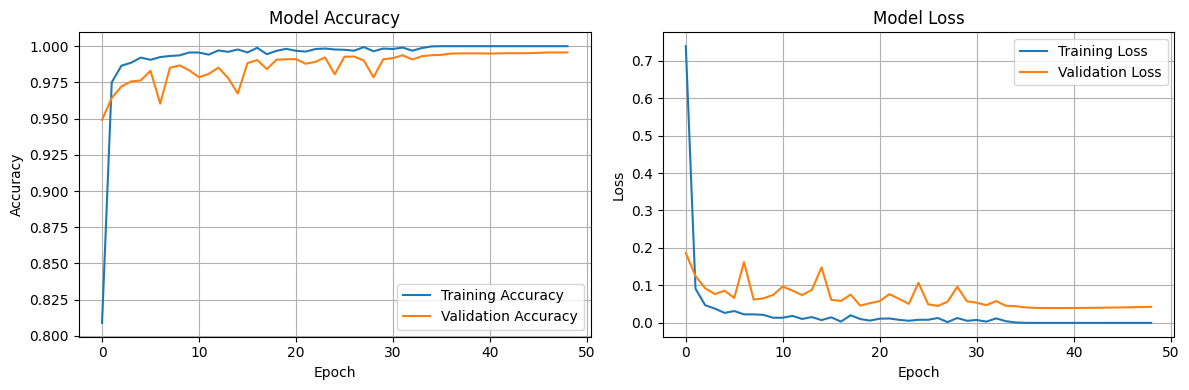

In [ ]:
# If you haven't loaded the data yet, uncomment and run the line below
# X_train, y_train, X_test, y_test = load_and_preprocess_data()

# Implement early stopping as mentioned in slide 11
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = giordynet.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=50,  # Using a high number with early stopping
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Save the model
giordynet.save('giordynet_full.h5')

# Evaluate the model on test set
test_loss, test_acc = giordynet.evaluate(X_test, y_test, verbose=1)
print(f"\nTest accuracy: {test_acc*100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict classes for test set
y_pred = np.argmax(giordynet.predict(X_test), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot performance metrics similar to those in slide 13
print("Model Performance Summary:")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Convert to TFLite format (float32 - no quantization)
print("Converting model to TFLite format (float32)...")
converter = tf.lite.TFLiteConverter.from_keras_model(giordynet)
tflite_float_model = converter.convert()

# Save the float model
with open('giordynet_float.tflite', 'wb') as f:
    f.write(tflite_float_model)
print(f"Float TFLite model size: {len(tflite_float_model) / 1024:.2f} KB")

# Check model details
interpreter = tf.lite.Interpreter(model_content=tflite_float_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"Input type: {input_details[0]['dtype']}")
print(f"Output type: {output_details[0]['dtype']}")

In [ ]:
# Integer-Only Quantization (everything quantized)
print("Converting model using Integer-Only Quantization...")
# Define representative dataset function for quantization
def representative_data_gen():
    for i in range(min(500, len(X_train))): # Use up to 500 samples for calibration
        sample = X_train[i:i+1].astype(np.float32)
        yield [sample]

converter = tf.lite.TFLiteConverter.from_keras_model(giordynet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_integer_only = converter.convert()

# Save the integer-only model
with open('giordynet_integer_only.tflite', 'wb') as f:
    f.write(tflite_integer_only)
print(f"Integer-only model size: {len(tflite_integer_only) / 1024:.2f} KB")

# Check model details
interpreter = tf.lite.Interpreter(model_content=tflite_integer_only)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"Input type: {input_details[0]['dtype']}")
print(f"Output type: {output_details[0]['dtype']}")

In [ ]:
# Import time for timing measurements
import time

# Define evaluation function for quantized models
def evaluate_tflite_model(tflite_model, model_name, num_test_samples=1000):
    """Evaluate a TFLite model on the test set"""
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print(f"\nEvaluating {model_name} on {num_test_samples} test samples:")
    input_type = input_details[0]['dtype']
    output_type = output_details[0]['dtype']

    # Get quantization parameters if available
    input_scale = input_details[0]['quantization'][0]
    input_zero_point = input_details[0]['quantization'][1]
    output_scale = output_details[0]['quantization'][0]
    output_zero_point = output_details[0]['quantization'][1]
    has_input_quant = input_scale != 0  # If scale is 0, quantization is not applied
    has_output_quant = output_scale != 0

    if has_input_quant:
        print(f"Input quantization: scale={input_scale}, zero_point={input_zero_point}")
    if has_output_quant:
        print(f"Output quantization: scale={output_scale}, zero_point={output_zero_point}")

    # Only use as many samples as we have in the test set
    num_test_samples = min(num_test_samples, len(X_test))

    # Test on multiple examples
    correct = 0
    total_inference_time = 0  # Track only inference time

    for i in tqdm(range(num_test_samples)):
        # Prepare input tensor
        test_image = X_test[i:i+1]
        true_class = y_test[i]

        if input_type == np.int8 and has_input_quant:
            # Quantize the input
            test_image = test_image / input_scale + input_zero_point
            test_image = np.clip(test_image, -128, 127).astype(np.int8)
        else:
            # Use floating point input
            test_image = test_image.astype(np.float32)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], test_image)

        # Measure ONLY the inference time
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()

        # Accumulate the inference time
        total_inference_time += (end_time - start_time)

        # Get output
        output = interpreter.get_tensor(output_details[0]['index'])

        # If output is quantized, dequantize it
        if output_type == np.int8 and has_output_quant:
            output = (output.astype(np.float32) - output_zero_point) * output_scale

        # Get predicted class
        predicted_class = np.argmax(output)

        if predicted_class == true_class:
            correct += 1

    # Calculate metrics
    accuracy = correct / num_test_samples
    avg_inference_time = total_inference_time / num_test_samples  # Average inference time per sample

    print(f"Final accuracy on {num_test_samples} test samples: {accuracy*100:.2f}%")
    print(f"Total inference time: {total_inference_time:.4f} seconds")
    print(f"Average inference time per sample: {avg_inference_time*1000:.4f} ms")

    return accuracy, avg_inference_time

In [ ]:
# Evaluate both models
print("Evaluating both models on test dataset...")
num_test_samples = 1000  # Adjust based on your computational resources

# Evaluate float model
accuracy_float, time_float = evaluate_tflite_model(
    tflite_float_model, "Float model (baseline)", num_test_samples)

# Evaluate integer-only model
accuracy_int, time_int = evaluate_tflite_model(
    tflite_integer_only, "Integer-only quantization", num_test_samples)

# Print comparison summary
print("\nModel Comparison Summary:")
print("-" * 80)
print(f"{'Model Type':<25} | {'Size (KB)':<10} | {'Accuracy (%)':<12} | {'Inference Time (ms)':<20}")
print("-" * 80)
print(f"{'Float (baseline)':<25} | {len(tflite_float_model)/1024:<10.2f} | {accuracy_float*100:<12.2f} | {time_float*1000:<20.2f}")
print(f"{'Integer-only':<25} | {len(tflite_integer_only)/1024:<10.2f} | {accuracy_int*100:<12.2f} | {time_int*1000:<20.2f}")
print("-" * 80)

# Calculate size reduction and speedup
size_reduction = (1 - len(tflite_integer_only)/len(tflite_float_model)) * 100
speedup = time_float / time_int
accuracy_loss = (accuracy_float - accuracy_int) * 100

print(f"\nQuantization Benefits:")
print(f"Size reduction: {size_reduction:.2f}%")
print(f"Speedup: {speedup:.2f}x")
print(f"Accuracy loss: {accuracy_loss:.2f}%")

In [ ]:
# Visualize comparison
plt.figure(figsize=(15, 5))

# Size comparison
plt.subplot(1, 3, 1)
sizes = [len(tflite_float_model)/1024, len(tflite_integer_only)/1024]
plt.bar(['Float', 'Integer-only'], sizes, color=['blue', 'green'])
plt.title('Model Size Comparison (KB)')
plt.ylabel('Size (KB)')
plt.grid(axis='y', alpha=0.3)

# Accuracy comparison
plt.subplot(1, 3, 2)
accuracies = [accuracy_float*100, accuracy_int*100]
plt.bar(['Float', 'Integer-only'], accuracies, color=['blue', 'green'])
plt.title('Model Accuracy Comparison (%)')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)

# Inference time comparison
plt.subplot(1, 3, 3)
times = [time_float*1000, time_int*1000]
plt.bar(['Float', 'Integer-only'], times, color=['blue', 'green'])
plt.title('Inference Time per Sample (ms)')
plt.ylabel('Time (ms)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Generate C source file from the integer-only TFLite model
!xxd -i giordynet_integer_only.tflite > traffic_sign_model_data.cc

# Check the file size
!ls -lh traffic_sign_model_data.cc

-rw-r--r-- 1 root root 660K May 22 11:21 traffic_sign_model_data.cc


In [ ]:
def prepare_test_images_for_pico():
    """
    Process test images from the dataset for Pico inferencing
    """
    # Select a few test images from different classes
    test_indices = []
    selected_classes = [14, 1, 12, 38]  # Stop sign, speed limit 30km/h, priority road, keep right

    # Find one example of each selected class
    for cls in selected_classes:
        for i, label in enumerate(y_test):
            if label == cls:
                test_indices.append(i)
                break

    # Create C arrays for test images
    test_image_arrays = []
    for i, idx in enumerate(test_indices):
        # Get the class name and ID for this image
        class_id = int(y_test[idx])

        # The model expects int8 input with these quantization parameters:
        # scale=0.003921568859368563, zero_point=-128
        img = X_test[idx]  # Already normalized to [0,1]

        # Apply quantization
        img_quant = img / 0.003921568859368563 - 128
        img_quant = np.clip(img_quant, -128, 127).astype(np.int8)
        img_quant = img_quant.squeeze()  # Remove the channel dimension

        # Create a C array for this image
        array_name = f"test_image_{i}"

        # Convert to C array
        flat_image = img_quant.flatten()
        c_array = f"const int8_t {array_name}[] = {{\n"
        for j in range(0, len(flat_image), 12):
            row = flat_image[j:j+12]
            c_array += "  " + ", ".join([f"{int(val)}" for val in row]) + ",\n"
        c_array = c_array[:-2] + "\n};\n\n"

        test_image_arrays.append(c_array)

        # Show the image and its class
        print(f"Image {i}: Class {class_id} - {class_names[class_id]}")
        plt.figure(figsize=(3, 3))
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        plt.title(f"Class {class_id}")
        plt.axis('off')
        plt.show()

    # Create header file with all test images
    test_images_header = """#ifndef TEST_IMAGES_H
#define TEST_IMAGES_H

// Test images converted to int8_t arrays for Raspberry Pi Pico inference
// These images are quantized with scale=0.003921568859368563, zero_point=-128

"""

    # Add each image array to the header
    for array in test_image_arrays:
        test_images_header += array

    # Close the header
    test_images_header += "#endif // TEST_IMAGES_H\n"

    # Write the header file
    with open('test_images.h', 'w') as f:
        f.write(test_images_header)

    print(f"Created test_images.h with {len(test_indices)} test images")

# Define class names for better visualization
class_names = [
    "Speed limit (20km/h)", "Speed limit (30km/h)", "Speed limit (50km/h)",
    "Speed limit (60km/h)", "Speed limit (70km/h)", "Speed limit (80km/h)",
    "End of speed limit (80km/h)", "Speed limit (100km/h)", "Speed limit (120km/h)",
    "No passing", "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection", "Priority road", "Yield", "Stop",
    "No vehicles", "Vehicles over 3.5 metric tons prohibited", "No entry",
    "General caution", "Dangerous curve to the left", "Dangerous curve to the right",
    "Double curve", "Bumpy road", "Slippery road", "Road narrows on the right",
    "Road work", "Traffic signals", "Pedestrians", "Children crossing",
    "Bicycles crossing", "Beware of ice/snow", "Wild animals crossing",
    "End of all speed and passing limits", "Turn right ahead", "Turn left ahead",
    "Ahead only", "Go straight or right", "Go straight or left", "Keep right",
    "Keep left", "Roundabout mandatory", "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
]

# Process the test images
prepare_test_images_for_pico()